In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from edward import models as edm
#tfe.enable_eager_execution()

In [136]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings, pickle, time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from matplotlib import pyplot as plt

warnings.simplefilter('ignore')

def build_toy_dataset():
    features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    df = pd.read_csv('./test-winequality-white.csv', sep=';')
    X = df[features].values
    y = (df.quality >= 7).values.astype(np.float32)

    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    return X, y

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    #h = np.matmul(h, W_2) + b_2
    h = sigmoid(np.matmul(h, W_2) + b_2)
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

In [128]:
alls = time.time()
J = 10000
B = 5000
#burnin = 500
print('Reading test data...')
X_test, y_test = build_toy_dataset()
print('Reading sampled weights...')
with open('../smc2/fast-theta'+'-'+str(J)+'-'+str(B),'rb') as f:
    outputs = np.array(pickle.load(f))

Reading test data...
Reading sampled weights...


In [129]:
outputs.shape

(5000, 175)

In [130]:
#calculate the errs
y_preds = []
for theta in outputs:
    y_pred = unpack_thete_get_outputs(X_test, theta)
    y_preds.append(y_pred)
y_preds = np.array(y_preds)
errs = []
for i in range(rows):
    for j in range(cols):
        data = outputs[:, i*cols+j]
        mu, sigma = np.mean(data), np.std(data)
        opt = cfs[i*cols+j]
        errs.append(round(np.abs(opt - mu) / sigma, 2)) 
plt.hist(errs)
plt.show()

(array([143.,  10.,   6.,   5.,   1.,   3.,   3.,   2.,   1.,   1.]),
 array([ 0.   ,  3.155,  6.31 ,  9.465, 12.62 , 15.775, 18.93 , 22.085,
        25.24 , 28.395, 31.55 ]),
 <a list of 10 Patch objects>)

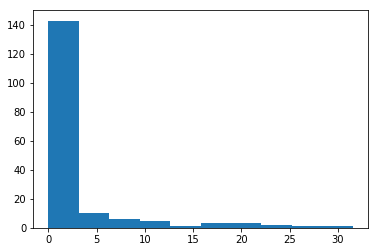

In [132]:
y_p = np.sum(y_preds, axis=0)
y_p.shape

(980,)

In [133]:
roc_auc_score(y_test, y_p)

0.8040421586347738

In [139]:
def plot_hist(data, ax, bins=50, title=''):
    ax.hist(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    ax.set_title(title+': '+str("%.3f" % mu)+','+str("%.3f" % sigma))
    return mu, sigma

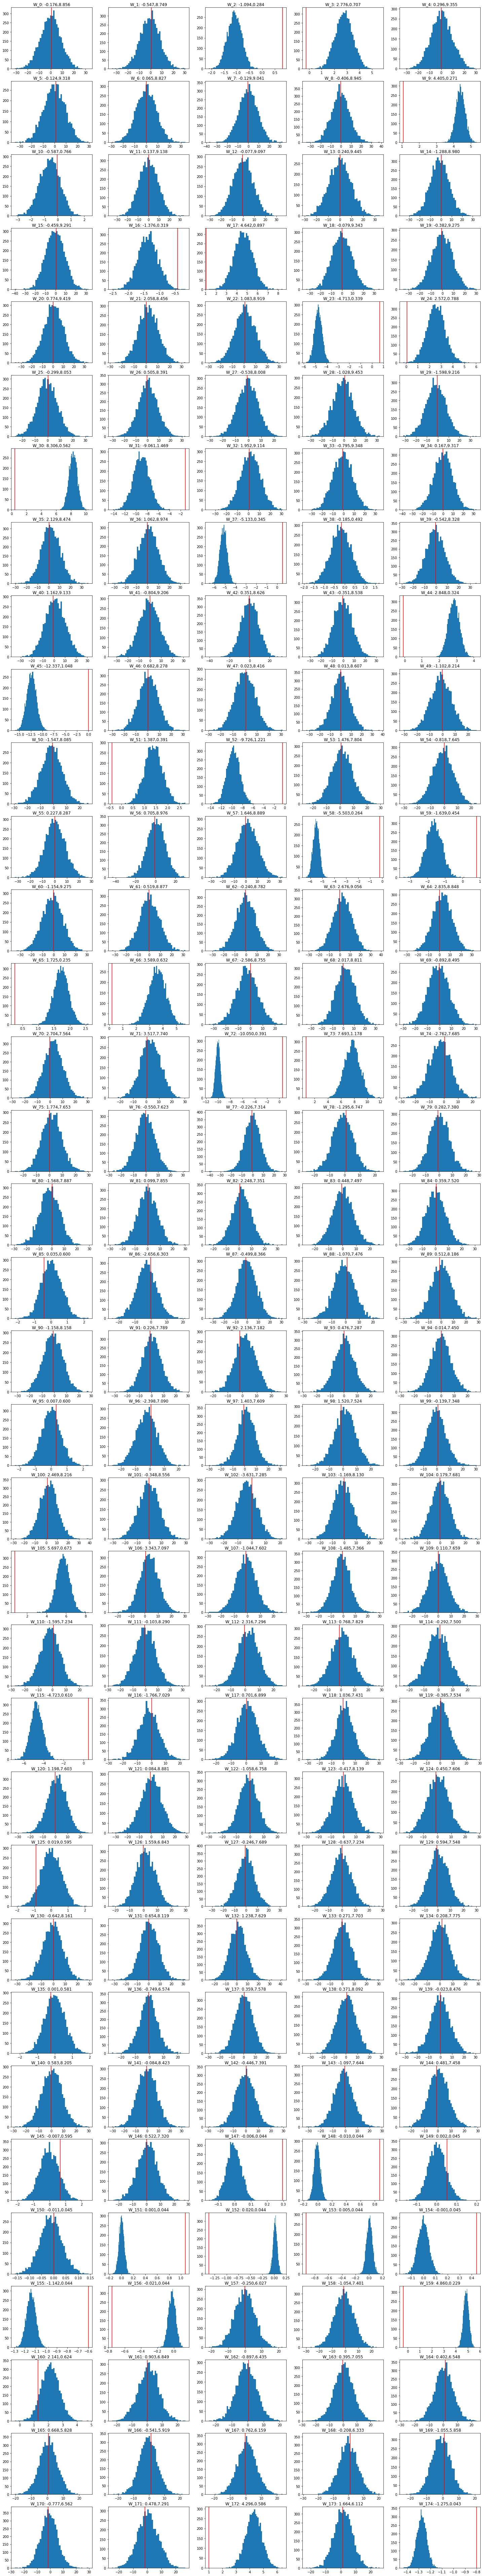

In [140]:
#20000-500-B4m
rows, cols = 35, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
#errs = []
for i in range(rows):
    for j in range(cols):
        mu, sigma = plot_hist(outputs[:, i*cols+j], axes[i, j], 50, 'W_'+str(i*cols+j))
        opt = cfs[i*cols+j]
        #errs.append(round(np.abs(opt - mu) / sigma, 2)) 
        axes[i,j].axvline(opt,color='red')
plt.show()

In [137]:
'''def np_neural_network(X, W_0, W_1, b_0, b_1):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.matmul(h, W_1) + b_1
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*14], [11, 14])
    W_1 = np.reshape(theta[11*14: 11*14+14*1], [14, 1])
    b_0 = np.reshape(theta[11*14+14*1:11*14+14*1+14], [14])
    b_1 = np.reshape(theta[11*14+14*1+14:], [1])
    return np_neural_network(X, W_0, W_1, b_0, b_1)
'''
print('Calculating results...')
aucs = []
accs = []
f1s = []
threshold = 0.5
for theta in outputs:
    y_pred = unpack_thete_get_outputs(X_test, theta)
    #print(y_pred)
    aucs.append(roc_auc_score(y_test, y_pred))
    #y_pred[y_pred>=threshold] = 1
    #y_pred[y_pred<threshold] = 0
    accs.append(accuracy_score(y_test, y_pred.round()))
    f1s.append(f1_score(y_test, y_pred.round()))

Calculating results...


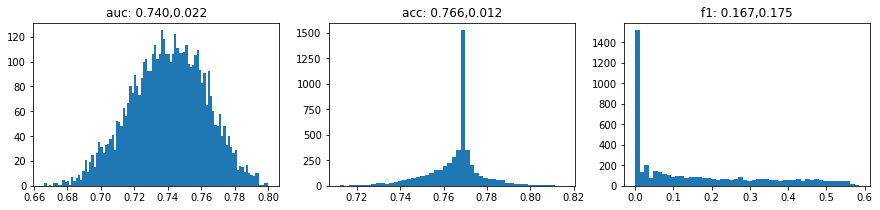

In [138]:
#test
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

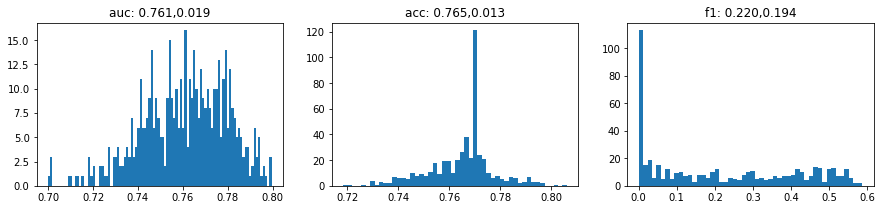

In [74]:
#B5m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

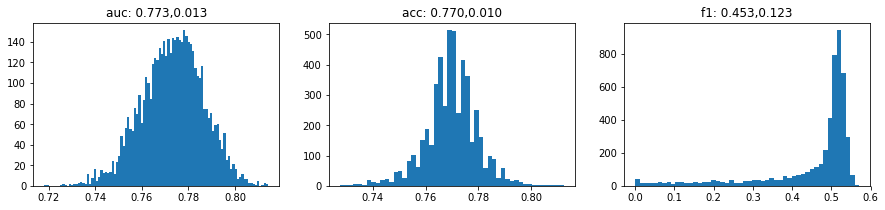

In [69]:
#B4m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

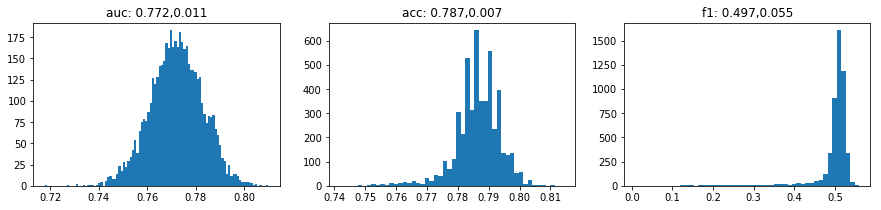

In [48]:
#B3m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

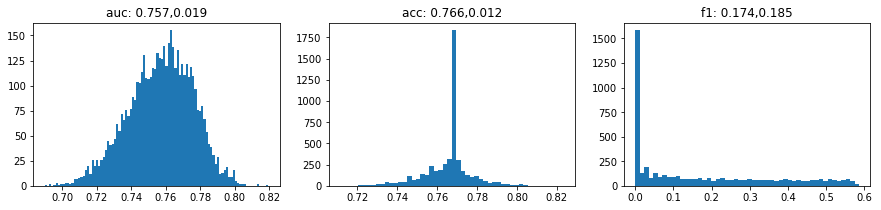

In [45]:
#B2m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

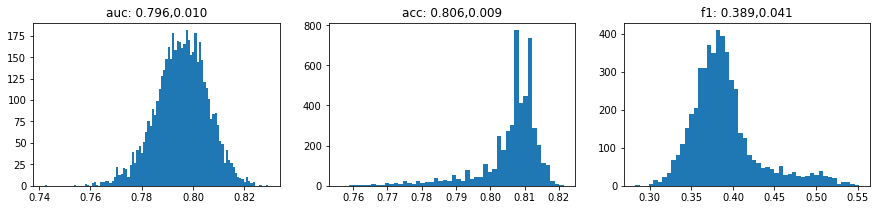

In [61]:
#B1m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

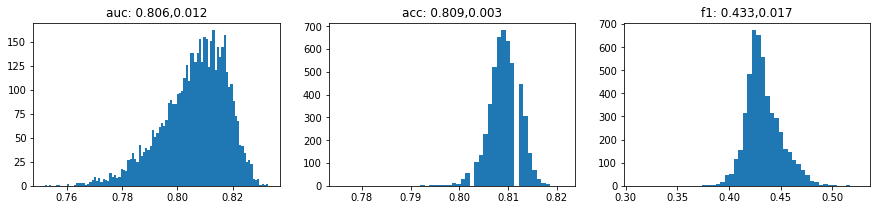

In [37]:
#2m-2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

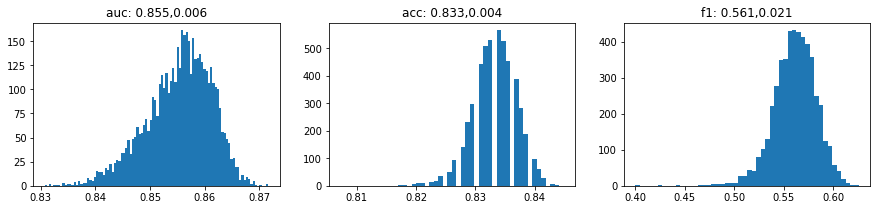

In [30]:
#2h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

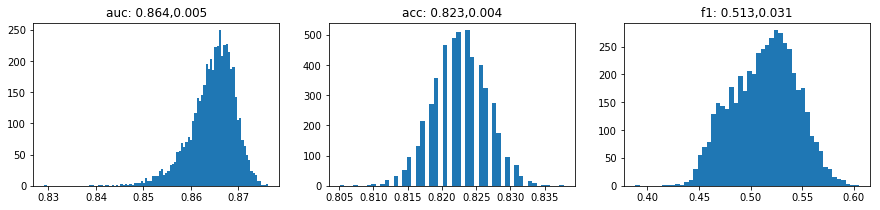

In [33]:
#1h-10v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

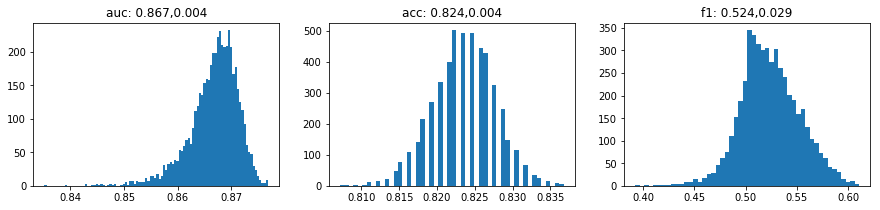

In [26]:
#1h-1v
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
def build_toy_dataset():
    features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    df = pd.read_csv('./train-winequality-white.csv', sep=';')
    X = df[features].values
    y = (df.quality >= 7).values.astype(np.float32)

    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    return X, y

def build_toy_testset():
    features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    df = pd.read_csv('./test-winequality-white.csv', sep=';')
    X = df[features].values
    y = (df.quality >= 7).values.astype(np.float32)

    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    return X, y


In [6]:
X, y = build_toy_dataset()
X_test, y_test = build_toy_testset()
print(X.shape, y.shape, X_test.shape, y_test.shape)

(3918, 11) (3918,) (980, 11) (980,)


In [7]:
clf = MLPClassifier(solver='adam',activation='tanh',alpha=0.0001,hidden_layer_sizes=(7,10),max_iter=3000)  # 神经网络输入为2，第一隐藏层神经元个数为5，第二隐藏层神经元个数为2，输出结果为2分类。
clf.fit(X, y)
print('Shape of weights: ',[coef.shape for coef in clf.coefs_])

Shape of weights:  [(11, 7), (7, 10), (10, 1)]


In [72]:
y_pred = clf.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,y_pred)
y_pred[y_pred>=threshold] = 1
y_pred[y_pred<threshold] = 0
acc = accuracy_score(y_test,y_pred,normalize=True)
print(roc, acc)

0.8429320907959906 0.8081632653061225


In [8]:
cfs = []
for w,b in zip(clf.coefs_,clf.intercepts_):
    print(w.shape, b.shape)
    cfs = np.concatenate((cfs, np.reshape(w, [-1]), np.reshape(b, [-1])),axis=0)

(11, 7) (7,)
(7, 10) (10,)
(10, 1) (1,)


In [9]:
cfs.shape

(175,)

In [11]:
import numpy as np
import pandas as pd

features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
df = pd.read_csv('../winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [17]:
df = df.sample(frac=1.0)  # 全部打乱
cut_idx = int(round(0.2 * df.shape[0]))
df_test, df_train = df.iloc[:cut_idx], df.iloc[cut_idx:]
print df.shape, df_test.shape, df_train.shape

(4898, 12) (980, 12) (3918, 12)


In [26]:
df_train.to_csv('./train-winequality-white.csv',index=False,sep=';')
df_test.to_csv('./test-winequality-white.csv',index=False,sep=';')

In [28]:
test = pd.read_csv('./test-winequality-white.csv',sep=';')
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.16,0.30,13.7,0.056,33.0,168.0,0.99825,2.90,0.44,8.7,7
1,6.9,0.32,0.27,16.0,0.034,58.0,185.0,0.99938,3.34,0.60,9.0,6
2,6.3,0.20,0.40,1.5,0.037,35.0,107.0,0.99170,3.46,0.50,11.4,6
3,5.3,0.60,0.34,1.4,0.031,3.0,60.0,0.98854,3.27,0.38,13.0,6
4,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6


In [77]:
from edward.models import Categorical, Bernoulli

In [81]:
a = Bernoulli(probs=[0.8])
with tf.Session() as sess:
    mya = sess.run(a.sample(1000))

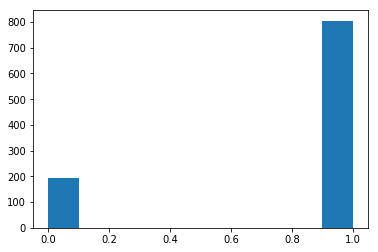

In [83]:
plt.hist(mya[:])
plt.show()

In [11]:
mya.shape

(1000, 2)

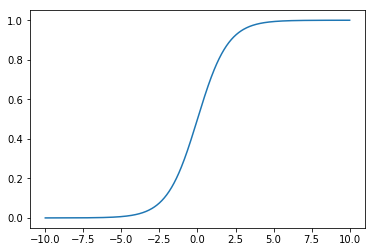

In [16]:
x = np.linspace(-10, 10, 500)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

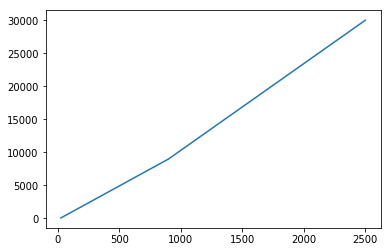

In [60]:
x = [5**2, 30**2, 50**2]
y = [82, 9000, 30000]
plt.plot(x, y)
plt.show()

In [55]:
import edward.models as edm

Instructions for updating:
Use the retry module or similar alternatives.


In [66]:
ys = pd.read_csv('../ys.csv')
ys.head()

,temperature.SI,pressure.SI,humidity.SI,wind_speed.SI,PM2.5.SI,NO2.SI,CO.SI,O3.SI,SO2.SI
0,0.301003,0.875627,0.14,0.3875,0.385321,0.124031,0.00000,0.186380,0.878049
1,0.297659,0.870612,0.15,0.2750,0.408257,0.131783,0.30303,0.164875,0.756098
2,0.295987,0.860582,0.16,0.1875,0.431193,0.147287,0.30303,0.136201,0.756098
3,0.299331,0.857573,0.17,0.1500,0.435780,0.178295,0.30303,0.114695,0.731707
4,0.284281,0.852558,0.22,0.1500,0.454128,0.224806,0.30303,0.089606,0.829268


In [153]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network_1h(X, W_0, W_1, b_0, b_1):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.matmul(h, W_1) + b_1
    return np.reshape(h, [-1])

def unpack_thete_get_outputs_1h(X, theta):
    W_0 = np.reshape(theta[0:11*14], [11, 14])
    W_1 = np.reshape(theta[11*14: 11*14+14*1], [14, 1])
    b_0 = np.reshape(theta[11*14+14*1:11*14+14*1+14], [14])
    b_1 = np.reshape(theta[11*14+14*1+14:], [1])
    return np_neural_network_1h(X, W_0, W_1, b_0, b_1)

def np_neural_network_2h_B(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    #h = np.matmul(h, W_2) + b_2
    h = sigmoid(np.matmul(h, W_2) + b_2)
    return np.reshape(h, [-1])

def unpack_thete_get_outputs_2h_B(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network_2h_B(X, W_0, W_1, W_2, b_0, b_1, b_2)

def np_neural_network_2h(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    h = np.matmul(h, W_2) + b_2
    return np.reshape(h, [-1])

def unpack_thete_get_outputs_2h(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network_2h(X, W_0, W_1, W_2, b_0, b_1, b_2)

In [157]:
import os 

def r_get_roc(thetafile, sign):
    with open(thetafile,'rb') as f:
        outputs = np.array(pickle.load(f))
    
    if(sign == 'B'):
        func = unpack_thete_get_outputs_2h_B
    elif(sign == 'N2'):
        func = unpack_thete_get_outputs_2h
    else:
        func = unpack_thete_get_outputs_1h
        
    y_preds = []
    for theta in outputs:
        y_pred = func(X_test, theta)
        y_preds.append(y_pred)
    y_preds = np.array(y_preds)
    
    y_p = np.sum(y_preds, axis=0)
    return roc_auc_score(y_test, y_p)

g = os.walk("../smc2")  

info = dict()
for path,dir_list,file_list in g:  
    for file_name in file_list:
        if("theta" in file_name):
            if("B" in file_name):
                sign = 'B'
            elif("2h" in file_name):
                sign = 'N2'
            else:
                sign = 'N1'
            
            print(file_name, sign)
            thetafile = os.path.join(path, file_name)
            info[file_name] = r_get_roc(thetafile, sign)

B3m-fast-theta-20000-5000-2h-10v B
B2m-theta-20000-5000-2h-10v B
2mtheta-5000-5000-2h-10v N2
B5m-theta-20000-5000-2h-10v B
B4m-theta-20000-5000-2h-10v B
2mtheta-10000-5000-2h-10v N2
theta-10000-5000-1h-1v N1
theta-8000-5000-1h-10v N1
B2m-theta-5000-500-2h-10v B
theta-5000-5000-2h-10v N2
B1m-theta-10000-5000-2h-10v B
B5m-fast-theta-1000-500-2h-10v B
theta-8000-5000-2h-10v N2
theta-10000-5000-2h-10v N2
2mtheta-5000-3000-2h-10v N2
theta-5000-5000-1h-10v N1
B3m-fast-theta-10000-5000-2h-10v B
2mtheta-1000-500-2h-10v N2
theta-5000-5000-1h-1v N1
B5m-fast-theta-20000-5000-2h-10v B
theta-1000-100-1h-1v N1
B3m-theta-20000-5000-2h-10v B
B2m-theta-1000-500-2h-10v B
theta-1000-500-2h-10v N2
theta-10000-5000-1h-10v N1
theta-8000-5000-1h-1v N1


In [158]:
info

{'2mtheta-1000-500-2h-10v': 0.8134668200276988,
 '2mtheta-10000-5000-2h-10v': 0.8201744090514307,
 '2mtheta-5000-3000-2h-10v': 0.8082908851904884,
 '2mtheta-5000-5000-2h-10v': 0.8406199384990961,
 'B1m-theta-10000-5000-2h-10v': 0.8107966949132651,
 'B2m-theta-1000-500-2h-10v': 0.7960728621393864,
 'B2m-theta-20000-5000-2h-10v': 0.793496631534471,
 'B2m-theta-5000-500-2h-10v': 0.7758444637449825,
 'B3m-fast-theta-10000-5000-2h-10v': 0.8040421586347738,
 'B3m-fast-theta-20000-5000-2h-10v': 0.7923698974202483,
 'B3m-theta-20000-5000-2h-10v': 0.7861259125372644,
 'B4m-theta-20000-5000-2h-10v': 0.7832973404380179,
 'B5m-fast-theta-1000-500-2h-10v': 0.7950869697894416,
 'B5m-fast-theta-20000-5000-2h-10v': 0.7913546630360789,
 'B5m-theta-20000-5000-2h-10v': 0.7938252623177859,
 'theta-1000-100-1h-1v': 0.8391645736015586,
 'theta-1000-500-2h-10v': 0.8213422220135678,
 'theta-10000-5000-1h-10v': 0.8692695007159457,
 'theta-10000-5000-1h-1v': 0.8712236801953007,
 'theta-10000-5000-2h-10v': 0.863